In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## =========== FAKE JOB POSTING DETECTION ============¶
## NLP + Deep Learning Approach
## Dataset: fake_job_postings.csv (from Kaggle)
## Target: 'fraudulent' (0 = real, 1 = fake)

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

C:\Users\gunas\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\gunas\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\gunas\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...


True

## 2. Load Dataset

In [4]:
df = pd.read_csv(r"C:\Users\gunas\Downloads\fake_job_postings.csv\fake_job_postings.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 3 Basic EDA


Fraudulent distribution:
fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64


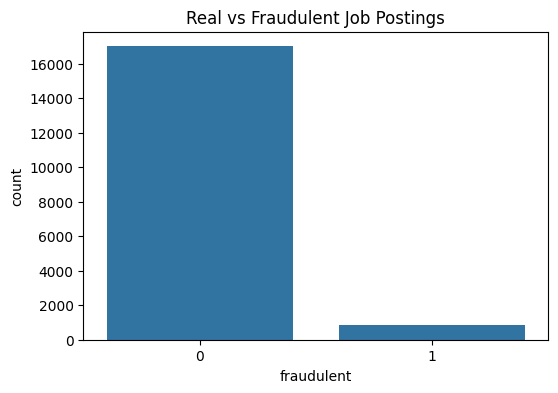

In [6]:
print("\nFraudulent distribution:")
print(df['fraudulent'].value_counts(normalize=True))

# Highly imbalanced → we will use class_weight later
plt.figure(figsize=(6,4))
sns.countplot(x='fraudulent', data=df)
plt.title('Real vs Fraudulent Job Postings')
plt.show()

## 4. Select Relevant Columns

In [7]:
# Text columns to combine
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']

In [8]:
# Categorical / binary columns
cat_columns = ['location', 'department', 'salary_range', 'employment_type',
               'required_experience', 'required_education', 'industry', 'function']

binary_columns = ['telecommuting', 'has_company_logo', 'has_questions']

In [11]:
# Fill NaN in text columns with empty string
for col in text_columns:
    df[col] = df[col].fillna('')

In [12]:
# Combine all text into one column
df['full_text'] = df[text_columns].agg(' '.join, axis=1)

In [13]:
# Fill NaN in categorical columns
for col in cat_columns:
    df[col] = df[col].fillna('missing')

## 5. NLP Preprocessing Function

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', ' ', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [17]:
# Apply cleaning
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

print("Cleaning text...")
df['cleaned_text'] = df['full_text'].apply(clean_text)
print("Text cleaning completed.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gunas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaning text...
Text cleaning completed.


## 6. Prepare Features

In [18]:
X_text = df['cleaned_text']
X_cat = df[cat_columns + binary_columns]
y = df['fraudulent']

## 7. TF-IDF Vectorization for Text (max_features=5000 to avoid memory issues)

In [19]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),        
    min_df=2,
    max_df=0.95
)


## 8. Split Data

In [20]:
X_text_train, X_text_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_text, X_cat, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
# Transform text
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

In [22]:
# Transform categorical + binary features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_columns),
        ('binary', 'passthrough', binary_columns)
    ]
)

In [23]:
X_cat_train_processed = preprocessor.fit_transform(X_cat_train)
X_cat_test_processed = preprocessor.transform(X_cat_test)

## 9. Combine TF-IDF + Categorical Features (Sparse Matrix → Dense for Keras)

In [24]:
from scipy.sparse import hstack

In [25]:
X_train = hstack([X_text_train_tfidf, X_cat_train_processed])
X_test = hstack([X_text_test_tfidf, X_cat_test_processed])

# Convert to dense 
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

print("Final feature matrix shape:", X_train_dense.shape)

Final feature matrix shape: (14304, 9887)


## 10. Handle Class Imbalance with class_weight

In [27]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [28]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       5,062,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,235,201 (19.97 MB)

 Trainable params: 5,235,201 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

## 12. Train Model

In [32]:
# Get unique class labels
classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Convert to dictionary
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

{np.int64(0): np.float64(0.5254573506722504), np.int64(1): np.float64(10.32034632034632)}


In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - Precision: 0.3330 - Recall: 0.6857 - accuracy: 0.9174 - loss: 0.3776 - val_Precision: 0.4144 - val_Recall: 0.9098 - val_accuracy: 0.9360 - val_loss: 0.1605
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - Precision: 0.6503 - Recall: 0.9696 - accuracy: 0.9730 - loss: 0.0899 - val_Precision: 0.5378 - val_Recall: 0.9098 - val_accuracy: 0.9595 - val_loss: 0.1204
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - Precision: 0.8097 - Recall: 0.9875 - accuracy: 0.9880 - loss: 0.0330 - val_Precision: 0.4596 - val_Recall: 0.9398 - val_accuracy: 0.9458 - val_loss: 0.1826
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - Precision: 0.8841 - Recall: 0.9946 - accuracy: 0.9934 - loss: 0.0142 - val_Precision: 0.7603 - val_Recall: 0.8346 - val_accuracy: 0.9801 - val_loss: 0.0766
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - Precision: 0.9756 - Recall: 1.0000 - accuracy: 0.9988 - loss: 0.0026 - val_Precision: 0.8295 - v

## 13. Evaluate

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_prob = model.predict(X_test_dense)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.82      0.89      0.86       173

    accuracy                           0.99      3576
   macro avg       0.91      0.94      0.92      3576
weighted avg       0.99      0.99      0.99      3576

ROC AUC Score: 0.987693619536655


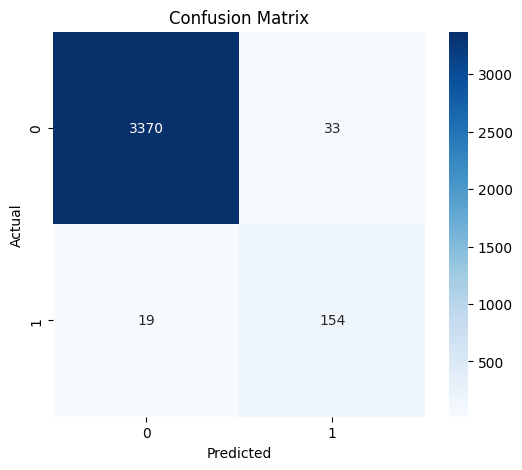

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 14. Save Model & Vectorizer

In [38]:
model.save('fraudulent_job_model.keras')
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(preprocessor, 'categorical_preprocessor.pkl')

print("Model and preprocessors saved!")

Model and preprocessors saved!


## 15. Testing

In [42]:
test_job = {
    'title': 'Data Entry Clerk - Work From Home $5000/week',
    'location': 'missing',
    'department': 'missing',
    'salary_range': 'missing',
    'company_profile': '',
    'description': 'Easy job! Just enter data from home and get paid big money every week. No experience needed.',
    'requirements': 'Must have computer and internet. Small registration fee to start.',
    'benefits': 'Unlimited earning potential! Be your own boss!',
    'telecommuting': 1,
    'has_company_logo': 0,
    'has_questions': 0,
    'employment_type': 'missing',
    'required_experience': 'missing',
    'required_education': 'missing',
    'industry': 'missing',
    'function': 'missing'
}

# Prediction function (uses already loaded model, tfidf, preprocessor)
def predict_single_job(job_dict):
    df_new = pd.DataFrame([job_dict])
    
    # Fill missing columns safely
    for col in text_columns:
        df_new[col] = df_new.get(col, '').fillna('')
    for col in cat_columns:
        df_new[col] = df_new.get(col, 'missing').fillna('missing')
    for col in binary_columns:
        df_new[col] = df_new.get(col, 0).fillna(0)
    
    # Combine and clean text
    df_new['full_text'] = df_new[text_columns].agg(' '.join, axis=1)
    df_new['cleaned_text'] = df_new['full_text'].apply(clean_text)
    
    # Vectorize
    text_vec = tfidf.transform(df_new['cleaned_text'])
    cat_vec = preprocessor.transform(df_new[cat_columns + binary_columns])
    X_new = hstack([text_vec, cat_vec]).toarray()
    
    # Predict
    prob = model.predict(X_new, verbose=0)[0][0]
    prediction = 'FRAUDULENT ⚠️' if prob > 0.5 else 'REAL ✅'
    return prob, prediction

# Run prediction
probability, result = predict_single_job(test_job)

print("\n=== SINGLE SAMPLE PREDICTION ===\n")
print(f"Job Title: {test_job['title']}")
print(f"Fraud Probability: {probability:.4f}")
print(f"Final Prediction : {result}")

if probability > 0.5:
    print("\n🚨 This job posting looks highly suspicious / likely fake!")
else:
    print("\n✅ This job posting appears legitimate.")


=== SINGLE SAMPLE PREDICTION ===

Job Title: Data Entry Clerk - Work From Home $5000/week
Fraud Probability: 1.0000
Final Prediction : FRAUDULENT ⚠️

🚨 This job posting looks highly suspicious / likely fake!
